In [75]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.aqua import QuantumInstance, run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from quantum_utils import circle_notation
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Produce the Circuit of the following form.

[Tutorial](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html)

```p cnf 4 6
1 -2 3 -4 0
1 -2 3 4 0
-1 0
1 4 0
-1 -3 4 0
-3 0```

This circuit represent the following SAT problem:
v1, v2, v3, v4

```(v1, not v2, v3, not v4) and 
(v1, not v2, v3, v4) and
(not v1) and
(v1, v4) and
(not v1, not v3, v4) and
(not v3)```

In [76]:
vars(quantum_instance).keys()

dict_keys(['_backend', '_run_config', '_backend_config', '_compile_config', '_qjob_config', '_noise_config', '_backend_options', '_meas_error_mitigation_cls', '_meas_error_mitigation_fitters', '_meas_error_mitigation_method', '_cals_matrix_refresh_period', '_meas_error_mitigation_shots', '_skip_qobj_validation', '_circuit_summary', '_job_callback'])

In [77]:
def set_bits(a, b):
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    if a == 1:
        qc.x(qr[0])
    if b == 1:
        qc.x(qr[1])
        
    return qc

def get_circle_notation(qc):
    backends = Aer.get_backend("statevector_simulator")
    job = execute(qc, backends)
    result = job.result()
    sv = result.get_statevector()
    circle_notation(sv, rows=1)
    return sv


In [78]:
# def OR(input1,input2):
  
#     q = QuantumRegister(3) # two qubits in which to encode the input, and one for the output
#     c = ClassicalRegister(1) # a bit to store the output
#     qc = QuantumCircuit(q, c) # this is where the quantum program goes
#     qc.h((q[0], q[1]))
#     qc.x((q[0], q[1]))
#     qc.toffoli(q[0], q[1], q[2])
#     qc.x((q[0], q[1], q[2]))
#     qc.barrier()
#     # YOUR QUANTUM PROGRAM GOES HERE
#     qc.measure(q[2],c[0]) # YOU CAN CHANGE THIS IF YOU WANT TO
    
#     # We'll run the program on a simulator
#     backend = Aer.get_backend('qasm_simulator')
#     # Since the output will be deterministic, we can use just a single shot to get it
#     job = execute(qc,backend,shots=1,memory=True)
#     output = job.result().get_memory()[0]
    
#     return output, qc

In [165]:
def OR(qc, ctrl_idxs, tgt_idx):
    """ add or gate to qc at qubit q1 and q2 
    qc: QuantumRegister
    ctrl_idxs: list of int indices
    tgt_idx: int idx
    """
    qr = qc.qregs[0]
    aqr = qc.qregs[1]
    ctrl_qs = [qr[i] for i in ctrl_idxs]
    tgt_q = qr[tgt_idx]
    qc.x(ctrl_qs)
    qc.mct(ctrl_qs, tgt_q, aqr)
    qc.x(ctrl_qs+[tgt_q])
    qc.barrier()
    return qc

def OR_inv(qc, ctrl_idxs, tgt_idx):
    """ add or gate to qc at qubit q1 and q2 
    qc: QuantumRegister
    ctrl_idxs: list of int indices
    tgt_idx: int idx
    """
    qr = qc.qregs[0]
    aqr = qc.qregs[1]
    ctrl_qs = [qr[i] for i in ctrl_idxs]
    tgt_q = qr[tgt_idx]
    qc.x(ctrl_qs+[tgt_q])
    qc.mct(ctrl_qs, tgt_q, aqr)
    qc.x(ctrl_qs)
    qc.barrier()
    return qc

def NOT(qc, idxs):
    qr = qc.qregs[0]
    qs = [qr[i] for i in idxs]
    qc.x(qs)
    return qc
    
def build_qc(n_qubits, n_cbits):
    qr = QuantumRegister(n_qubits) 
    aqr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_cbits) 
    qc = QuantumCircuit(qr, aqr, cr)
    return qc

def mirror(qc, qs):
    qc.h(qs)
    qc.x(qs)
    qc.mcrz(pi, qs[:-1], qs[-1])
    qc.x(qs)
    qc.h(qs)
    return qc
    
def solution():
    n_lit, n_clause = 3, 2
    qc = build_qc(n_lit+n_clause, n_lit)
    qr = qc.qregs[0]
    cr = qc.cregs[0]
    lits = qr[:n_lit]  # literals
    clauses = qr[n_lit:]
    qc.h(lits)
    
    # -1 -2 -3 0
    qc = NOT(qc, [0, 1, 2])
    qc = OR(qc, [0, 1, 2], 0+n_lit)
    qc = NOT(qc, [0, 1, 2])
    # 1 -2 3 0
    qc = NOT(qc, [1])
    qc = OR(qc, [0, 1, 2], 1+n_lit)
    qc = NOT(qc, [1])
    
    # phase z
    qc.mcrz(pi, clauses[:-1], clauses[-1])
    
    # uncompute 
    qc = NOT(qc, [1])
    qc = OR_inv(qc, [0, 1, 2], 1+n_lit)
    qc = NOT(qc, [1])
    qc = NOT(qc, [0, 1, 2])
    qc = OR_inv(qc, [0, 1, 2], 0+n_lit)    
    qc = NOT(qc, [0, 1, 2])
    
    qc = mirror(qc, lits)
    for i in range(len(cr)):
        qc.measure(qr[i], cr[i])
    
    return qc

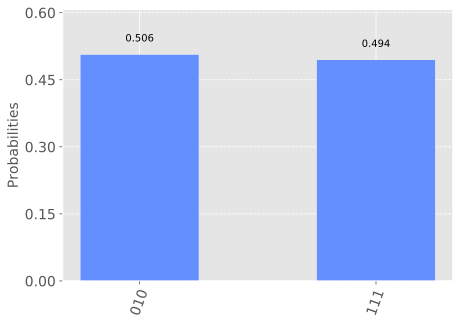

In [166]:
qc = solution()
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()

# quantum_instance = QuantumInstance(backend, shots=1024)
# result = qc.run(quantum_instance)
plot_histogram(result.get_counts())


# qc.draw(output='mpl')

In [157]:
result.get_counts()

{'1101': 60,
 '0111': 80,
 '1111': 64,
 '1001': 53,
 '1010': 58,
 '1011': 70,
 '1000': 63,
 '1110': 50,
 '0011': 54,
 '0101': 42,
 '1100': 87,
 '0010': 68,
 '0110': 67,
 '0100': 65,
 '0001': 76,
 '0000': 67}

In [136]:
qc = build_qc(4, 1)
qc = OR(qc, [0,1,2], 3)
# qc.draw(output='mpl')

0


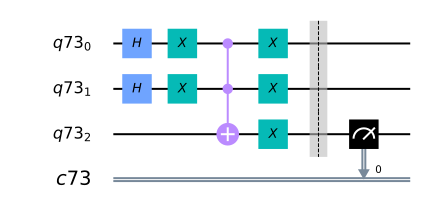

In [79]:
output, qc = OR(0,0)
print(output)
qc.draw(output='mpl')

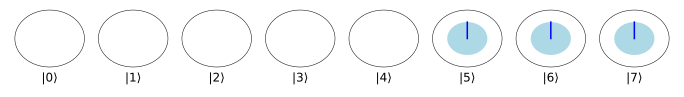

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.57735027+0.j, 0.57735027+0.j, 0.57735027+0.j])

In [80]:
get_circle_notation(qc)

In [73]:
print('\nResults for the OR gate')
for input1 in ['0','1']:
    for input2 in ['0','1']:
        print('    Inputs',input1,input2,'give output',OR(input1,input2))


Results for the OR gate
    Inputs 0 0 give output ('1', <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a8418d0>)
    Inputs 0 1 give output ('0', <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a7cad90>)
    Inputs 1 0 give output ('0', <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a6aaf50>)
    Inputs 1 1 give output ('1', <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12a885b90>)


### Solution
---

In [3]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

In [138]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 2
-1 -2 -3 0
1 -2 3 0
'''

In [139]:
oracle = LogicalExpressionOracle(input_3sat)
grover = Grover(oracle)

[1, 2, 3]


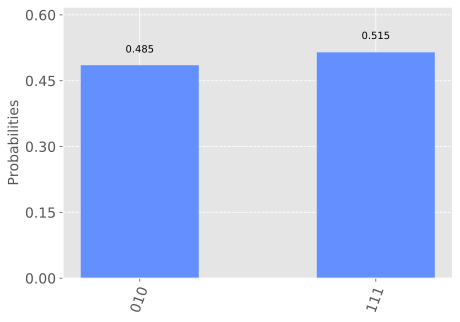

In [140]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])
plot_histogram(result['measurement'])